Rooftop Segmentation & Roofline Detection Pipeline

This script fetches a satellite image from Google Maps given any GPS coordinates, 
then detects the rooftop border and internal rooflines using two DeepLabV3+ models 
(trained for roof edge and roofline segmentation).

The pipeline performs the following:
1. Fetches satellite image using Google Maps Static API.
2. Detects the main rooftop using a segmentation model and isolates it.
3. Crops and re-processes the image to refine the roof boundary.
4. Uses a second model to detect roofline separators (to divide slanted roof sections).
5. Visualizes the border, rooflines, and separated sections.
6. Outputs GPS coordinates of roof corners, which can be used for area or solar panel planning.

Dependencies: segmentation_models_pytorch, albumentations, OpenCV, PyTorch, PIL, matplotlib.
NOTE: Based on the location of .pth files, you might need to change the path.

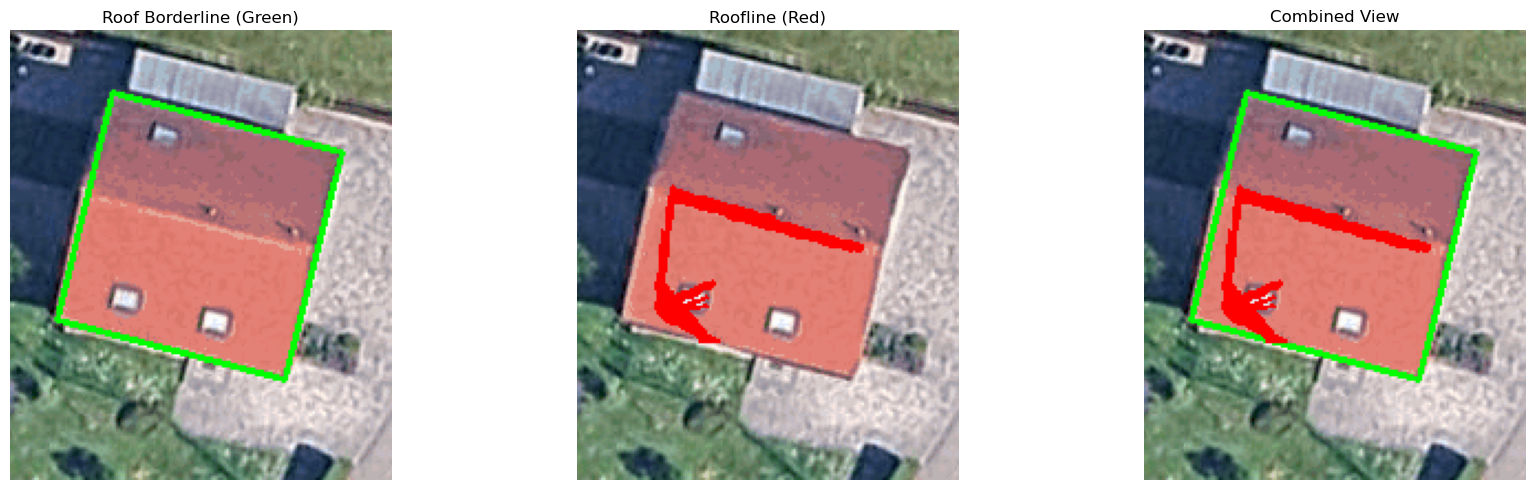

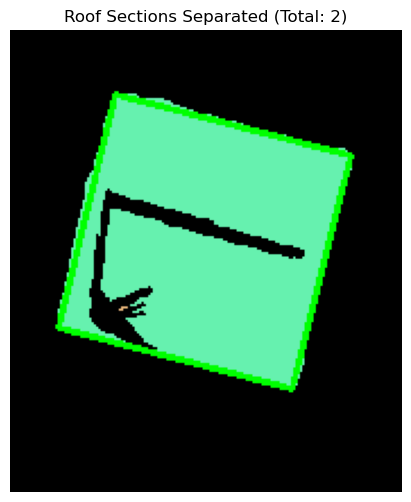


GPS Coordinates of Roof Edge:
50.172186, 8.720103
50.172098, 8.720069
50.172075, 8.720207
50.172163, 8.720242


In [82]:
#INSTALLATION NOTE
# Install these libraries the first time you run the script
# !pip install segmentation-models-pytorch albumentations opencv-python-headless

#IMPORTS
import torch, cv2, math, numpy as np, matplotlib.pyplot as plt, requests
from PIL import Image
from io import BytesIO
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import functional as TF
from skimage.morphology import skeletonize

#CONFIG
GOOGLE_API_KEY = "YOUR API KEY"  # Replace with your Google Maps Static API key
MODEL_PATH_BORDER = "best_roof_model.pth"  # Path to roof border detection model
MODEL_PATH_ROOFLINE = "best_model_roofline.pth"  # Path to roofline segmentation model
LAT, LON = #50.17213556298505, 8.720151033418475  # Set GPS coordinates for the target house
ZOOM = 20
IMG_SIZE = 640
PADDING = 20
THRESH = 0.5
EPSILON_RATIO = 0.01
TILE = 256

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#LOAD MODELS
# Load pretrained roof border detection model
border_model = smp.DeepLabV3Plus("resnet101", encoder_weights=None, in_channels=3, classes=1).to(device)
border_model.load_state_dict(torch.load(MODEL_PATH_BORDER, map_location=device))
border_model.eval()

# Load pretrained roofline detection model
roofline_model = smp.DeepLabV3Plus("resnet101", encoder_weights=None, in_channels=3, classes=1, activation="sigmoid").to(device)
roofline_model.load_state_dict(torch.load(MODEL_PATH_ROOFLINE, map_location=device))
roofline_model.eval()

#IMAGE TRANSFORMATIONS
# Resize and normalize input image before model inference
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.5,)*3, std=(0.5,)*3),
    ToTensorV2()
])

#IMAGE FETCHING
# Fetch satellite image from Google Maps
def fetch_satellite_image(lat, lon, zoom=20, size=640, api_key=GOOGLE_API_KEY):
    url = f"https://maps.googleapis.com/maps/api/staticmap?center={lat},{lon}&zoom={zoom}&size={size}x{size}&maptype=satellite&key={api_key}"
    r = requests.get(url)
    if r.status_code == 200:
        img = Image.open(BytesIO(r.content))
        path = f"roof_{lat}_{lon}.png"
        img.save(path)
        return path
    else:
        raise RuntimeError(f"Google Maps API Error: {r.status_code}")

# COORDINATE UTILS
# Convert lat/lon to world coordinates
def _lnglat_to_world(lng, lat):
    siny = math.sin(lat * math.pi / 180)
    siny = min(max(siny, -0.9999), 0.9999)
    x = TILE * (0.5 + lng / 360)
    y = TILE * (0.5 - math.log((1 + siny) / (1 - siny)) / (4 * math.pi))
    return x, y

# Convert pixel coordinates back to lat/lon
center_world_x, center_world_y = _lnglat_to_world(LON, LAT)
pixels_per_tile = 2 ** ZOOM

def pixel_to_latlon(px, py):
    world_x = center_world_x + (px - IMG_SIZE/2) / pixels_per_tile
    world_y = center_world_y + (py - IMG_SIZE/2) / pixels_per_tile
    lng = (world_x / TILE - 0.5) * 360
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * world_y / TILE)))
    lat = lat_rad * 180 / math.pi
    return lat, lng

# Apply morphological operations to clean up the binary mask
def morph_clean(mask):
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    return mask

# Predict binary mask using the border model
def predict_mask(image_np):
    H, W = image_np.shape[:2]
    input_tensor = transform(image=image_np)["image"].unsqueeze(0).to(device)
    with torch.no_grad():
        pred = torch.sigmoid(border_model(input_tensor)).squeeze().cpu().numpy()
        pred = cv2.resize(pred, (W, H), interpolation=cv2.INTER_LINEAR)
        return (pred > THRESH).astype(np.uint8) * 255

# Connect broken roofline segments using Hough line transform
def stitch_roofline(mask):
    closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8), iterations=2)
    lines = cv2.HoughLinesP(closed, 1, np.pi/180, threshold=30, minLineLength=30, maxLineGap=20)
    stitched = np.zeros_like(mask)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(stitched, (x1, y1), (x2, y2), 255, 2)
    return stitched

# Generate closed roofline mask using model + post-processing
def get_closed_roofline_mask(image_np):
    img_pil = Image.fromarray(image_np)
    w, h = img_pil.size
    m = max(w, h)
    pad_left = (m - w) // 2
    pad_top = (m - h) // 2
    img_padded = TF.pad(img_pil, (pad_left, pad_top, m - w - pad_left, m - h - pad_top), fill=0)
    img_resized = TF.resize(img_padded, (256, 256))
    img_tensor = TF.to_tensor(img_resized).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = roofline_model(img_tensor)[0, 0].cpu().numpy()
    binary_mask = (pred > 0.5).astype(np.uint8)
    skeleton = skeletonize(binary_mask.astype(bool)).astype(np.uint8)
    thick_line = cv2.dilate(skeleton, np.ones((3, 3), np.uint8), iterations=2)
    stitched = stitch_roofline(thick_line)

    closed_mask = np.zeros_like(stitched)
    contours, _ = cv2.findContours(stitched, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(closed_mask, contours, -1, 255, thickness=cv2.FILLED)

    closed_resized = cv2.resize(closed_mask, (image_np.shape[1], image_np.shape[0]), interpolation=cv2.INTER_NEAREST)
    return closed_resized

#MAIN PIPELINE
def run_pipeline(lat, lon):
    path = fetch_satellite_image(lat, lon)
    orig = np.array(Image.open(path).convert("RGB"))
    H, W = orig.shape[:2]
    img_center = (W//2, H//2)

    # Run initial full-image border detection
    mask1 = predict_mask(orig)
    mask1 = morph_clean(mask1)

    # Find roof contours, select the one closest to image center
    contours, _ = cv2.findContours(mask1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print("No roof found.")
        return

    def centroid(c):
        M = cv2.moments(c)
        if M["m00"] == 0: return float('inf')
        cx = int(M["m10"]/M["m00"])
        cy = int(M["m01"]/M["m00"])
        return np.sqrt((cx - img_center[0])**2 + (cy - img_center[1])**2)

    best = min(contours, key=centroid)
    x, y, w, h = cv2.boundingRect(best)
    x1, y1 = max(0, x - PADDING), max(0, y - PADDING)
    x2, y2 = min(W, x + w + PADDING), min(H, y + h + PADDING)

    # Crop around best roof
    cropped = orig[y1:y2, x1:x2]
    mask2 = predict_mask(cropped)
    mask2 = morph_clean(mask2)

    contours2, _ = cv2.findContours(mask2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours2:
        print("Cropped prediction failed.")
        return

    # Simplify roof boundary using polygon approximation
    final = max(contours2, key=cv2.contourArea)
    eps = EPSILON_RATIO * cv2.arcLength(final, True)
    approx = cv2.approxPolyDP(final, eps, True).squeeze()
    approx[:, 0] += x1
    approx[:, 1] += y1
    closed = np.vstack([approx, approx[0]])

    # Detect internal rooflines
    separator_mask = get_closed_roofline_mask(cropped)

    # Overlay for visualization
    roofline_overlay = cropped.copy()
    roofline_overlay[separator_mask == 255] = [255, 0, 0]

    border_overlay = cropped.copy()
    cv2.polylines(border_overlay, [closed.astype(np.int32)-[x1,y1]], isClosed=True, color=(0,255,0), thickness=2)

    combined = border_overlay.copy()
    combined[separator_mask == 255] = [255, 0, 0]

    # Display overlays
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1); plt.imshow(border_overlay); plt.title("Roof Borderline (Green)"); plt.axis("off")
    plt.subplot(1, 3, 2); plt.imshow(roofline_overlay); plt.title("Roofline (Red)"); plt.axis("off")
    plt.subplot(1, 3, 3); plt.imshow(combined); plt.title("Combined View"); plt.axis("off")
    plt.tight_layout(); plt.show()

    #ROOF SECTION PARTITION
    divided_mask = cv2.bitwise_and(mask2, cv2.bitwise_not(separator_mask))
    num_labels, labels = cv2.connectedComponents(divided_mask)

    # Display each section in a different color
    colored = np.zeros_like(cropped)
    for i in range(1, num_labels):
        color = np.random.randint(100, 255, size=3).tolist()
        colored[labels == i] = color
    cv2.polylines(colored, [closed.astype(np.int32)-[x1,y1]], isClosed=True, color=(0, 255, 0), thickness=2)

    plt.figure(figsize=(6, 6))
    plt.imshow(colored)
    plt.title(f"Roof Sections Separated (Total: {num_labels - 1})")
    plt.axis("off")
    plt.show()

    #COORDINATE OUTPUT
    print("\nGPS Coordinates of Roof Edge:")
    for x, y in approx:
        lat_, lon_ = pixel_to_latlon(x, y)
        print(f"{lat_:.6f}, {lon_:.6f}")

#RUN PIPELINE
run_pipeline(LAT, LON)
